# Formula 1 - Modelling

### Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm import tqdm
import math
from IPython.display import clear_output

In [3]:
from collections import defaultdict
import regex as re
import datetime

In [4]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import r2_score
import joblib

In [5]:
import xgboost
from xgboost import XGBRegressor

# Load The Data

In [6]:
driver_standings = pd.read_csv('./CSV/driver_standings.csv').drop(['Unnamed: 0'], axis=1)

In [7]:
constructor_standings = pd.read_csv('./CSV/constructor_standings.csv').drop(['Unnamed: 0'], axis=1)

In [8]:
main_df = pd.read_csv('./CSV/main_df.csv').drop(['Unnamed: 0'], axis=1)

In [9]:
main_df.head()

,season,round,race_name,name,constructor,grid,qual_position,q_best,q_worst,q_mean,...,circuitId,locality,country,type,direction,length,weather,finish_position,points,filled_splits
0,2014,1,australian,Nico Rosberg,mercedes,3.0,3.0,92.564,104.595,99.807667,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",1.0,25.0,0.000
1,2014,1,australian,Kevin Magnussen,mclaren,4.0,4.0,90.949,105.745,99.980333,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",2.0,18.0,26.777
2,2014,1,australian,Jenson Button,mclaren,10.0,11.0,91.396,104.437,97.916500,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",3.0,15.0,30.027
3,2014,1,australian,Fernando Alonso,ferrari,5.0,5.0,91.388,105.819,100.004000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",4.0,12.0,35.284
4,2014,1,australian,Valtteri Bottas,williams,15.0,10.0,91.601,108.147,101.200000,...,albert_park,Melbourne,Australia,Street circuit,Clockwise,5.303,"overcast, 19°c (66°f) dry",5.0,10.0,47.639


In [10]:
# age variable committed to csv as datetime type, loaded as a string. Reformat to remove ' days' from instances.

def day_split(age):
    return int(age.split(' ')[0])

main_df.ageDuringRace = main_df.ageDuringRace.apply(day_split)

In [11]:
main_df.dtypes

season               int64
round                int64
race_name           object
name                object
constructor         object
grid               float64
qual_position      float64
q_best             float64
q_worst            float64
q_mean             float64
ageDuringRace        int64
circuitId           object
locality            object
country             object
type                object
direction           object
length             float64
weather             object
finish_position    float64
points             float64
filled_splits      float64
dtype: object

In [12]:
race_dps = []

for years in np.array(main_df.season.unique()):
    race_dps.extend([(years, race_name) if race_name != '70th-anniversary' 
                     else (race_name.split('-')[0], race_name.split('-')[1], years)
                     for race_name in 
                     list(main_df[main_df.season == years]['race_name'].unique())])
    race_dps.extend([(years, 'usa') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='us'])
    race_dps.extend([(years, 'mexico') for race_name in
                 list(main_df[main_df.season == years]['race_name'].unique()) if race_name=='mexican'])

# Model Tuning

### Train-Test Split on pre-2020 to predict 2020 onwards

In [13]:
main = main_df.copy()

train = main[main.season<2020]
test = main[main.season==2020]

r_train = train.pop('finish_position')
y_train = train.pop('filled_splits')
p_train = train.pop('points')
X_train = train
r_test = test.pop('finish_position')
y_test = test.pop('filled_splits')
X_test = test
p_test = test.pop('points')

In [14]:
# Natural Language Processing
cvec_weather = CountVectorizer(stop_words='english', binary=True)#strip_words

# Dummification
ohe_direction = OneHotEncoder(handle_unknown='ignore')
ohe_country = OneHotEncoder(handle_unknown='ignore')
ohe_locality = OneHotEncoder(handle_unknown='ignore')
ohe_type = OneHotEncoder(handle_unknown='ignore')
ohe_season = OneHotEncoder(handle_unknown='ignore')
ohe_round = OneHotEncoder(handle_unknown='ignore')
ohe_qual_pos = OneHotEncoder(handle_unknown='ignore')
ohe_grid_pos = OneHotEncoder(handle_unknown='ignore')
ohe_racename = OneHotEncoder(handle_unknown='ignore')

# Standardisation
scaler_q_mean = StandardScaler(with_mean=False)
scaler_q_best = StandardScaler(with_mean=False)
scaler_q_worst = StandardScaler(with_mean=False)
scaler_length = StandardScaler(with_mean=False)
scaler_age = StandardScaler(with_mean=False)

In [15]:
col_trans = ColumnTransformer([
                               ('weather', cvec_weather, 'weather'),
                               ('direction', ohe_direction, ['direction']),
                               ('country', ohe_country, ['country']),
                               ('locality', ohe_locality, ['locality']),
                               ('type', ohe_type, ['type']),
                               ('season', ohe_season, ['season']),
                               ('round', ohe_round, ['round']),
                               ('qual_position', ohe_qual_pos, ['qual_position']),
                               ('grid', ohe_grid_pos, ['grid']),
                               ('race_name', ohe_racename, ['race_name']),
                               ('q_mean', scaler_q_mean, ['q_mean']),
                               ('q_best', scaler_q_best, ['q_best']),
                               ('q_worst', scaler_q_worst, ['q_worst']),
                               ('length', scaler_length, ['length']),
                               ('ageDuringRace', scaler_age, ['ageDuringRace'])
                              ], 
                             )

In [16]:
params = {'gamma': [None, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5],
          'learning_rate': [None, 0.01, 0.05, 0.1, 0,15, 0.2],
          'max_depth': [None, 5, 6, 8, 10, 12, 15],
          'n_estimators': [150],
          'reg_alpha': [None, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
          'reg_lambda': [None, 0.1, 0.2, 0.4, 0.6, 0.8, 1],
          'subsample': [None, 0.5, 0.6, 0.8, 1]}

In [17]:
def points(pos):
    if pos==1: return 25
    if pos==2: return 18
    if pos==3: return 15
    if pos==4: return 12
    if pos==5: return 10
    if pos==6: return 8
    if pos==7: return 6
    if pos==8: return 4
    if pos==9: return 2
    if pos==10: return 1
    return 0

def constructor(name):
    return main_df[main_df.name==name][constructor]

def driver_id(name):
    name = name.split()[1].strip(' ').lower()
    if name == 'fittipaldi':
        return 'pietro_fittipaldi'
    elif name == 'räikkönen':
        return 'raikkonen'
    elif name == 'pérez':
        return 'perez'
    elif name == 'hülkenberg':
        return 'hulkenberg'
    elif name == 'magnussen':
        return 'kevin_magnussen'
    elif name == 'verstappen':
        return 'max_verstappen'
    else:
        return name


# Set Scores Dictionaries

drivers = {'spearman': -math.inf,
           'pearson': -math.inf,
           'r2': -math.inf,
           'mse': -math.inf,
           'rmse': -math.inf}

constructors = {'spearman': -math.inf,
                'pearson': -math.inf,
                'r2': -math.inf,
                'mse': -math.inf,
                'rmse': -math.inf}

In [18]:
size = len(params['gamma'])*len(params['learning_rate'])*len(params['max_depth'])*len(params['n_estimators'])*len(params['reg_alpha'])*len(params['reg_lambda'])*len(params['subsample'])

progress = 0

In [19]:
print(size)

96040


In [20]:
for gamma in params['gamma']:
    for learning_rate in params['learning_rate']:
        for max_depth in params['max_depth']:
            for n_estimators in params['n_estimators']:
                for reg_alpha in params['reg_alpha']:
                    for reg_lambda in params['reg_lambda']:
                        for subsample in params['subsample']:
                            progress += 1
                            clear_output(wait=True)
                            print(f'{progress}/{size}')
                            try:
                                xgb = XGBRegressor(gamma=gamma, learning_rate=learning_rate, max_depth=max_depth, n_estimators=n_estimators, reg_alpha=reg_alpha, reg_lambda=reg_lambda, subsample=subsample, n_jobs=-2, verbosity=1)
                                pipe = make_pipeline(col_trans, xgb)
                                pipe.fit(X_train, y_train)
                                view_test = X_test.copy()
                                
                                view_test['pred'] = pipe.predict(X_test)
                                view_test['true'] = y_test
                                view_test['true_finish_positions'] = r_test
                                
                                test_indices = view_test.index
                                
                                view_train = X_train.copy()
                                view_train['true'] = y_train
                                view_train['pred'] = pipe.predict(X_train)
                                view_train['true_finish_positions'] = r_train
                                
                                train_indices = view_train.index
                                
                                overall = pd.concat([view_test, view_train])
                                overall.sort_values(['season', 'round', 'pred'], inplace=True)
                                
                                true_positions_test = []
                                indices_test = []
                                for race in race_dps:
                                    if race[1]=='anniversary':
                                        year = 2020
                                        circuit = '70th-anniversary'
                                    else:
                                        year = race[0]
                                        circuit = race[1]
                                    
                                    year_race = overall[(overall.season==year)&(overall.race_name==circuit)]
                                    
                                    def indexer(ind):
                                        return sorted(year_race.pred).index(ind)+1
                                    
                                    true_positions_test.extend(year_race.pred.apply(indexer))
                                    indices_test.extend(year_race.pred.apply(indexer).index)
                                positional_convert_test = pd.DataFrame(true_positions_test, index=indices_test).sort_index()
                                view_test['pred_positions'] = positional_convert_test
                                
                                true_positions_train = []
                                indices_train = []
                                for race in race_dps:
                                    if race[1]=='anniversary':
                                        year = 2020
                                        circuit = '70th-anniversary'
                                    else:
                                        year = race[0]
                                        circuit = race[1]
                                    year_race = overall[(overall.season==year)&(overall.race_name==circuit)]
                                    
                                    def indexer(ind):
                                        return sorted(year_race.pred).index(ind)+1
                                    
                                    true_positions_train.extend(year_race.pred.apply(indexer))
                                    indices_train.extend(year_race.pred.apply(indexer).index)
                                positional_convert_train = pd.DataFrame(true_positions_train, index=indices_train).sort_index()
                                view_train['pred_positions'] = positional_convert_train
                                
                                view_test['points'] = view_test.pred_positions.apply(points)
                                
                                driver_points = view_test[['name', 'points']]
                                predicted_standings_driver = driver_points.groupby('name').agg('sum').sort_values(by='points', ascending=False)
                                predicted_standings_driver.reset_index(inplace=True)
                                
                                predicted_standings_driver['driverId'] = predicted_standings_driver.name.apply(driver_id)
                                predicted_standings_driver.drop(['name'], axis=1, inplace=True)
                                predicted_standings_driver = predicted_standings_driver.reindex(columns=['driverId', 'points'])
                                
                                driver_comparison = driver_standings.drop(['position'], axis=1)
                                
                                driver_correlation_comparison = predicted_standings_driver.merge(driver_comparison, how='inner', on='driverId')
                                driver_correlation_comparison.columns=['driver', 'pred_points', 'true_points']
                                
                                def pred_indexer(ind, df=driver_correlation_comparison):
                                    return sorted(df.pred_points, reverse=True).index(ind)+1
                                def true_indexer(ind, df=driver_correlation_comparison):
                                    return sorted(df.true_points, reverse=True).index(ind)+1
                                
                                driver_correlation_comparison['pred_positions'] = driver_correlation_comparison.pred_points.apply(pred_indexer)
                                driver_correlation_comparison['true_positions'] = driver_correlation_comparison.true_points.apply(true_indexer)
                                driver_correlation_comparison['Pos Error (Diff: Pred - True)'] = driver_correlation_comparison.pred_positions - driver_correlation_comparison.true_positions
                                
                                spearman_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
                                pearson_d = round(driver_correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
                                r2_d = round(r2_score(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 4)
                                mse_d = round(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points']), 2)
                                rmse_d = round(np.sqrt(metrics.mean_squared_error(driver_correlation_comparison['true_points'], driver_correlation_comparison['pred_points'])), 3)
                                
                                constructor_points = view_test[['constructor', 'points']]
                                predicted_standings = constructor_points.groupby('constructor').agg('sum').sort_values(by='points', ascending=False)
                                predicted_standings.reset_index(inplace=True)
                                constructor_comparison = constructor_standings.drop(['position'], axis=1)
                                correlation_comparison = predicted_standings.merge(constructor_comparison, how='inner', on='constructor')
                                correlation_comparison.columns=['constructor', 'pred_points', 'true_points']
                                correlation_comparison['pred_positions'] = correlation_comparison.pred_points.apply(pred_indexer, df=correlation_comparison)
                                correlation_comparison['true_positions'] = correlation_comparison.true_points.apply(true_indexer, df=correlation_comparison)
                                
                                spearman = round(correlation_comparison[['pred_points', 'true_points']].corr(method='spearman').iloc[0][1], 4)
                                pearson = round(correlation_comparison[['pred_points', 'true_points']].corr(method='pearson').iloc[0][1], 4)
                                r2 = round(r2_score(correlation_comparison['true_points'], correlation_comparison['pred_points']), 4)
                                mse = metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])
                                rmse = round(np.sqrt(metrics.mean_squared_error(correlation_comparison['true_points'], correlation_comparison['pred_points'])), 3)
                                
                                if (drivers['pearson'] <= pearson_d) and (drivers['r2'] <= r2_d) and (constructors['pearson'] <= pearson) and (constructors['r2'] <= r2):
                                    
                                    best = {'gamma': gamma,
                                            'learning_rate': learning_rate,
                                            'max_depth': max_depth,
                                            'n_estimators': n_estimators,
                                            'reg_alpha': reg_alpha,
                                            'reg_lambda': reg_lambda,
                                            'subsample': subsample}

                                    drivers = {'spearman': spearman_d,
                                               'pearson': pearson_d,
                                               'r2': r2_d,
                                               'mse': mse_d,
                                               'rmse': rmse_d}
                                    
                                    constructors = {'spearman': spearman,
                                                    'pearson': pearson,
                                                    'r2': r2,
                                                    'mse': mse,
                                                    'rmse': rmse}
                                    
                                    model = xgb
                                    
                                    
                                    final_drivers = driver_correlation_comparison
                                    final_constructors = correlation_comparison
                                    
                                else:
                                    continue
                            except:
                                continue

96040/96040


In [21]:
best

{'gamma': 0.1,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 150,
 'reg_alpha': None,
 'reg_lambda': 0.2,
 'subsample': 1}

In [ ]:
best_parameters = {'gamma': 0.1,
                   'learning_rate': 0.2,
                   'max_depth': 6,
                   'n_estimators': 150,
                   'reg_alpha': None,
                   'reg_lambda': 0.2,
                   'subsample': 1}

# Driver Standings

In [23]:
final_drivers

,driver,pred_points,true_points,pred_positions,true_positions,Pos Error (Diff: Pred - True)
0,hamilton,330,347,1,1,0
1,bottas,269,223,2,2,0
2,max_verstappen,230,214,3,3,0
3,perez,119,125,4,4,0
4,ricciardo,114,119,5,5,0
5,norris,109,97,6,9,-3
6,albon,99,105,7,6,1
7,leclerc,92,98,8,8,0
8,sainz,82,105,9,6,3
9,stroll,68,75,10,10,0


Text(0, 0.5, 'True Points')

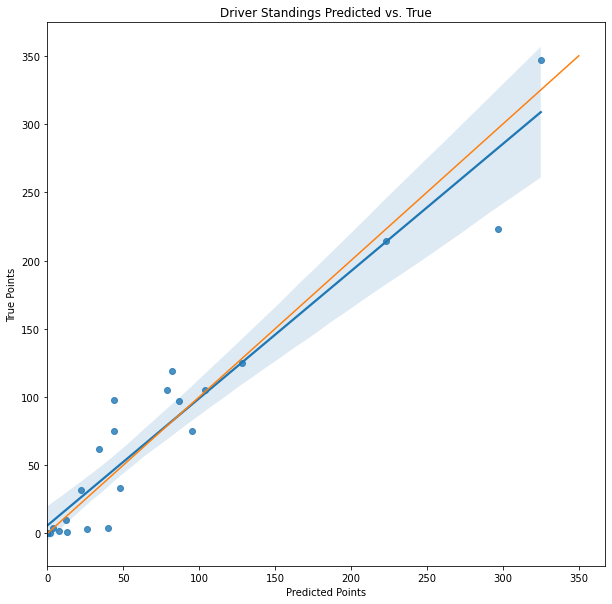

In [24]:
plt.subplots(figsize=(10, 10))
sns.regplot(data=driver_correlation_comparison, x='pred_points', y='true_points')
plt.plot([y_test.min(), 350], [y_test.min(), 350])
plt.title('Driver Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

In [30]:
drivers

{'spearman': 0.9705,
 'pearson': 0.9807,
 'r2': 0.9601,
 'mse': 300.74,
 'rmse': 17.342}

# Constructor Standings

In [25]:
final_constructors

,constructor,pred_points,true_points,pred_positions,true_positions
0,mercedes,617,573,1,1
1,red_bull,329,319,2,2
2,racing_point,203,195,3,4
3,mclaren,191,202,4,3
4,renault,143,181,5,5
5,ferrari,130,131,6,6
6,alphatauri,76,107,7,7
7,alfa,23,8,8,8
8,haas,3,3,9,9
9,williams,2,0,10,10


Text(0, 0.5, 'True Points')

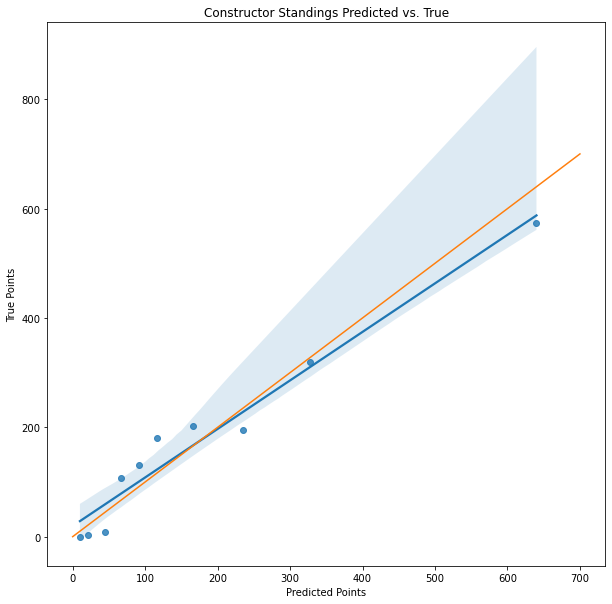

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.regplot(data=correlation_comparison, x='pred_points', y='true_points')
x_label=('Predicted Points')
plt.plot([y_test.min(), 700], [y_test.min(), 700])
plt.title('Constructor Standings Predicted vs. True')
plt.xlabel('Predicted Points')
plt.ylabel('True Points')

In [31]:
constructors

{'spearman': 0.9879,
 'pearson': 0.9941,
 'r2': 0.9823,
 'mse': 485.6,
 'rmse': 22.036}

# Model Save & Load

In [32]:
# Save the model

# joblib.dump(model, 'ignore/models/f1model_XGB.pkl')

['ignore/models/f1model_XGB.pkl']

In [28]:
# Load the saved model

# model = joblib.load('ignore/models/f1model_XGB.pkl')

In [33]:
pipe = make_pipeline(col_trans, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('weather',
                                                  CountVectorizer(binary=True,
                                                                  stop_words='english'),
                                                  'weather'),
                                                 ('direction',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['direction']),
                                                 ('country',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country']),
                                                 ('locality',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['locality']),
                    

In [90]:
pipe = make_pipeline(col_trans, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('weather',
                                                  CountVectorizer(binary=True,
                                                                  stop_words='english'),
                                                  'weather'),
                                                 ('direction',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['direction']),
                                                 ('country',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['country']),
                                                 ('locality',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['locality']),
                    

In [102]:
import sklearn
import warnings

def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [189]:
coefficients = pd.DataFrame(model.feature_importances_)
feature_names = get_feature_names(pipe['columntransformer'])

<ipython-input-102-aeb52d502674>:30: UserWarning: Transformer q_mean (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-102-aeb52d502674>:30: UserWarning: Transformer q_best (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-102-aeb52d502674>:30: UserWarning: Transformer q_worst (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-102-aeb52d502674>:30: UserWarning: Transformer length (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-102-aeb52d502674>:30: UserWarning: Transformer ageDuringRace (type StandardScaler) does 

In [266]:
features = pd.DataFrame(feature_names)
features['coeff'] = coefficients
features.set_index(0, inplace=True)
features.sort_values(by='coeff', ascending=True).head(50)

,coeff
0,
weather__speeds,0.0
weather__92,0.0
locality__x0_Monte-Carlo,0.0
weather__90,0.0
locality__x0_Montmeló,0.0
locality__x0_Montreal,0.0
locality__x0_Monza,0.0
locality__x0_Sakhir,0.0
locality__x0_Shanghai,0.0


In [267]:
features[features.coeff>0.0].sort_values(by='coeff', ascending=True).head(50)

,coeff
0,
round__x0_20,0.000085
weather__34,0.000193
weather__13,0.000195
weather__hour,0.000201
weather__2ft,0.000214
weather__8m,0.000223
country__x0_Austria,0.000228
qual_position__x0_11.0,0.000228
weather__36c,0.000247
